# Tutorial: Upload, access and explore your data in Azure Machine Learning

In this tutorial you learn how to:

> * Upload your data to cloud storage
> * Create an Azure Machine Learning data asset
> * Access your data in a notebook for interactive development
> * Create new versions of data assets

The start of a machine learning project typically involves exploratory data analysis (EDA), data-preprocessing (cleaning, feature engineering), and the building of Machine Learning model prototypes to validate hypotheses. This _prototyping_ project phase is highly interactive. It lends itself to development in an IDE or a Jupyter notebook, with a _Python interactive console_. This tutorial describes these ideas.

## Prerequisites

* If you opened this notebook from Azure Machine Learning studio, you need a compute instance to run the code. If you don't have a compute instance, select **Create compute** on the toolbar to first create one.  You can use all the default settings.  

    ![Create compute](./media/create-compute.png)

* If you're seeing this notebook elsewhere, complete [Create resources you need to get started](https://docs.microsoft.com/azure/machine-learning/quickstart-create-resources) to create an Azure Machine Learning workspace and a compute instance.

## Set your kernel

* If your compute instance is stopped, start it now.  
        
    ![Start compute](./media/start-compute.png)
    

* Once your compute instance is running, make sure the that the kernel, found on the top right, is 'Aml SDKv2 Py3_8' (if you followed notebook 00_SetupIpythonKernel)  .  If not, use the dropdown to select this kernel.

    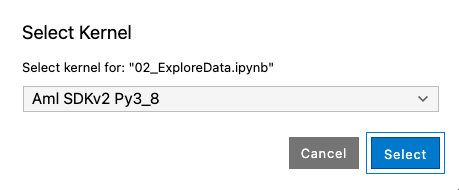
    
or `Python 3.10 - SDK v2` (if you skipped).

  ![Set the kernel](./media/set-kernel.png)

### The data used in this tutorial is in the data folder



[Learn more about this data on the UCI Machine Learning Repository.](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

## Create handle to workspace

Before we dive in the code, you need a way to reference your workspace. You'll create `ml_client` for a handle to the workspace.  You'll then use `ml_client` to manage resources and jobs.

In the next cell, enter your Subscription ID, Resource Group name and Workspace name. To find these values:

1. In the upper right Azure Machine Learning studio toolbar, select your workspace name.
1. Copy the value for workspace, resource group and subscription ID into the code.
1. You'll need to copy one value, close the area and paste, then come back for the next one.

In [ ]:
%pip install -U azure-ai-ml==1.5.0

In the next cell, enter your Subscription ID, Resource Group name and Workspace name. To find these values:

1. In the upper right Azure Machine Learning studio toolbar, select your workspace name.
1. Copy the value for workspace, resource group and subscription ID into the code.  
1. You'll need to copy one value, close the area and paste, then come back for the next one.

![image of workspace credentials](./media/find-credentials.png)

In [3]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="f1ea6ed8-82f3-416d-881b-8b376218bc85",
    resource_group_name="rg_aml",
    workspace_name="aml-default",
)

In [ ]:
# authenticate
credential = DefaultAzureCredential()
# # Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id="<SUBSCRIPTION_ID>",
    resource_group_name="<RESOURCE_GROUP>",
    workspace_name="<AML_WORKSPACE_NAME>",
)

> [!NOTE]
> Creating MLClient will not connect to the workspace. The client initialization is lazy, it will wait for the first time it needs to make a call (this will happen in the next code cell).


## Upload data to cloud storage

Azure Machine Learning uses Uniform Resource Identifiers (URIs), which point to storage locations in the cloud. A URI makes it easy to access data in notebooks and jobs. Data URI formats look similar to the web URLs that you use in your web browser to access web pages. For example:

* Access data from public https server: `https://<account_name>.blob.core.windows.net/<container_name>/<folder>/<file>`
* Access data from Azure Data Lake Gen 2: `abfss://<file_system>@<account_name>.dfs.core.windows.net/<folder>/<file>`

An Azure Machine Learning data asset is similar to web browser bookmarks (favorites). Instead of remembering long storage paths (URIs) that point to your most frequently used data, you can create a data asset, and then access that asset with a friendly name.

Data asset creation also creates a *reference* to the data source location, along with a copy of its metadata. Because the data remains in its existing location, you incur no extra storage cost, and don't risk data source integrity. You can create Data assets from Azure Machine Learning datastores, Azure Storage, public URLs, and local files.

> [!TIP]
> For smaller-size data uploads, Azure Machine Learning data asset creation works well for data uploads from local machine resources to cloud storage. This approach avoids the need for extra tools or utilities. However, a larger-size data upload might require a dedicated tool or utility - for example, **azcopy**. The azcopy command-line tool moves data to and from Azure Storage. Learn more about [azcopy](https://learn.microsoft.com/en-us/azure/storage/common/storage-use-azcopy-v10).

The next notebook cell creates the data asset. The code sample uploads the raw data file to the designated cloud storage resource.  

Each time you create a data asset, you need a unique version for it.  If the version already exists, you'll get an error.  In this code, we're using time to generate a unique version each time the cell is run.

You can also omit the **version** parameter, and a version number is generated for you, starting with 1 and then incrementing from there. In this tutorial, we want to refer to specific version numbers, so we create a version number instead.

In [2]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time

# update the 'my_path' variable to match the location of where you downloaded the data on your
# local filesystem

my_path = "./data/default_of_credit_card_clients.csv"
# set the version number of the data asset to the current UTC time
v1 = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())


my_data = Data(
    name="credit-card",
    version=v1,
    description="Credit card data",
    path=my_path,
    type=AssetTypes.URI_FILE,
)

# create data asset
ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Data asset created. Name: credit-card, version: 2023.09.06.135022


You can see the uploaded data by selecting **Data** on the left. You'll see the data is uploaded and a data asset is created:

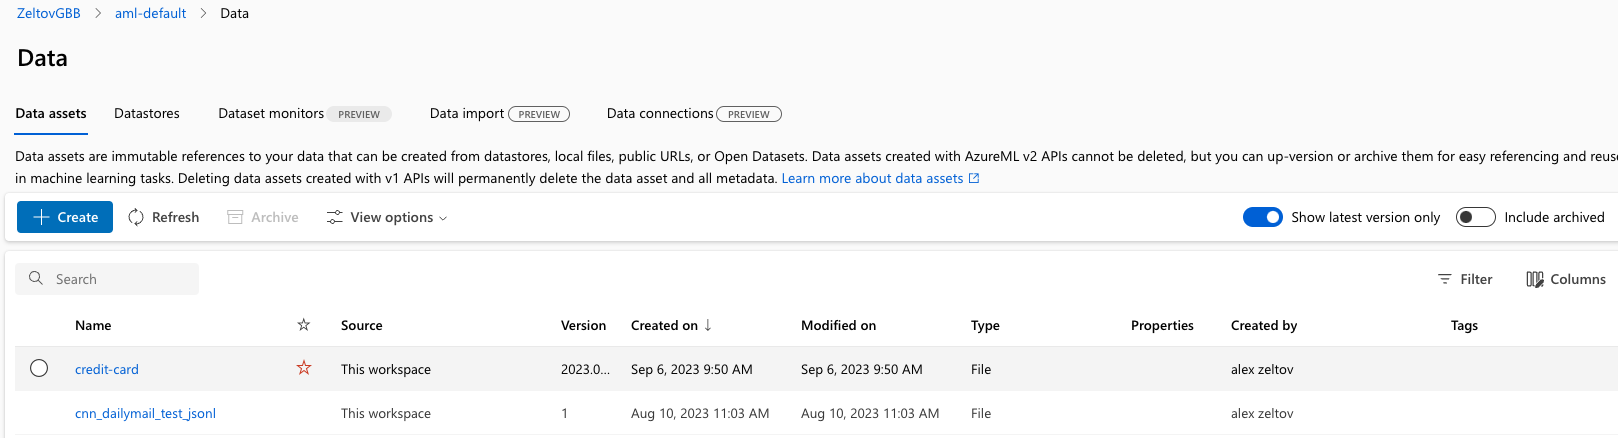

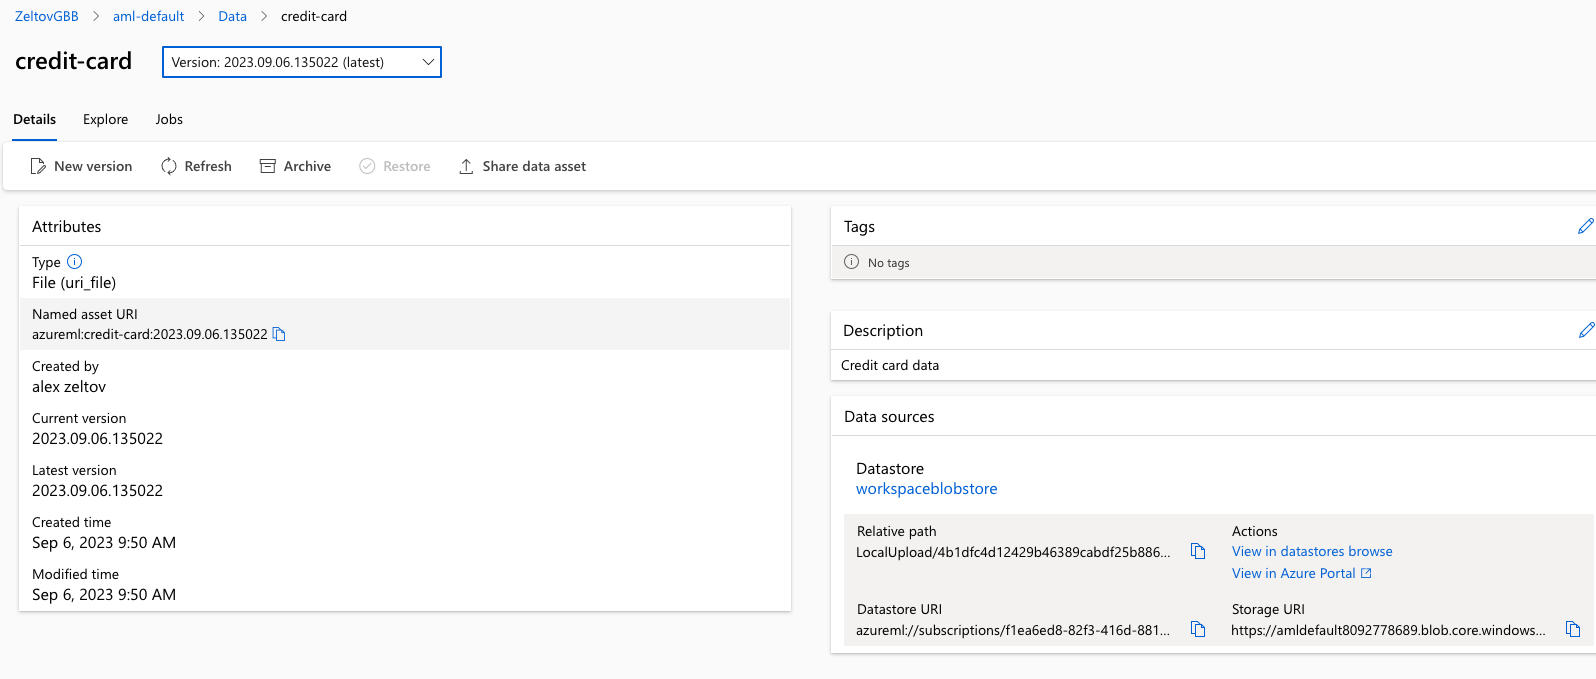

This data is named **credit-card**, and in the **Data assets** tab, we can see it in the **Name** column. This data uploaded to your workspace's default datastore named **workspaceblobstore**, seen in the **Data source** column. 

An Azure Machine Learning datastore is a *reference* to an *existing* storage account on Azure. A datastore offers these benefits:

1. A common and easy-to-use API, to interact with different storage types (Blob/Files/Azure Data Lake Storage) and authentication methods.
1. An easier way to discover useful datastores, when working as a team.
1. In your scripts, a way to hide connection information for credential-based data access (service principal/SAS/key).


## Access your data in a notebook

Pandas directly support URIs - this example shows how to read a CSV file from an Azure Machine Learning Datastore:

```
import pandas as pd

df = pd.read_csv("azureml://subscriptions/<subid>/resourcegroups/<rgname>/workspaces/<workspace_name>/datastores/<datastore_name>/paths/<folder>/<filename>.csv")
```

However, as mentioned previously, it can become hard to remember these URIs. Additionally, you must manually substitute all **<_substring_>** values in the **pd.read_csv** command with the real values for your resources. 

You'll want to create data assets for frequently accessed data. Here's an easier way to access the CSV file in Pandas:

> [!IMPORTANT]
> In a notebook cell, execute this code to install the `azureml-fsspec` Python library in your Jupyter kernel:

In [7]:
%pip install -U azureml-fsspec

  Obtaining dependency information for azureml-fsspec from https://files.pythonhosted.org/packages/9e/31/10f5c1841e2eba7984e1e5b13bd63ea7f8901872149967916e1891ec42d8/azureml_fsspec-1.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for azureml-dataprep<4.14.0a,>=4.12.0a from https://files.pythonhosted.org/packages/1f/f6/3e93d67408c8caacc6143552f10f286d167e021a6d0d9c272ba47d2ce71a/azureml_dataprep-4.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fsspec>=2021.6.1 from https://files.pythonhosted.org/packages/3a/9f/b40e8e5be886143379000af5fc0c675352d59e82fd869d24bf784161dc77/fsspec-2023.9.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.1/31.1 MB 30.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 64.5 MB/s eta 0:00:00
  Obtaining dependency information for azureml-dataprep-rslex~=2.19.0dev0 from https://files.pythonhosted.org/packages/d1/ff/7fd08ad922166525a3af34f9291cec1b44e00dd88c3422

In [8]:
import pandas as pd

# get a handle of the data asset and print the URI
#v1="2023.09.06.135022"
data_asset = ml_client.data.get(name="credit-card", version=v1)
print(f"Data asset URI: {data_asset.path}")

# read into pandas - note that you will see 2 headers in your data frame - that is ok, for now

df = pd.read_csv(data_asset.path)
df.head()

Data asset URI: azureml://subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourcegroups/rg_aml/workspaces/aml-default/datastores/workspaceblobstore/paths/LocalUpload/4b1dfc4d12429b46389cabdf25b886a2/default_of_credit_card_clients.csv


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


Read [Access data from Azure cloud storage during interactive development](how-to-access-data-interactive.md) to learn more about data access in a notebook.

## Create a new version of the data asset and store in Parquet file format

You might have noticed that the data needs a little light cleaning, to make it fit to train a machine learning model. It has:

* two headers
* a client ID column; we wouldn't use this feature in Machine Learning
* spaces in the response variable name

Also, compared to the CSV format, the Parquet file format becomes a better way to store this data. Parquet offers compression, and it maintains schema. Therefore, to clean the data and store it in Parquet, use:

In [9]:
%pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [10]:
# read in data again, this time using the 2nd row as the header
df = pd.read_csv(data_asset.path, header=1)
# rename column
df.rename(columns={"default payment next month": "default"}, inplace=True)
# remove ID column
df.drop("ID", axis=1, inplace=True)

# write file to filesystem
df.to_parquet("./data/cleaned-credit-card.parquet")

This table shows the structure of the data in the original **default_of_credit_card_clients.csv** file .CSV file downloaded in an earlier step. The uploaded data contains 23 explanatory variables and 1 response variable, as shown here:

|Column Name(s) | Variable Type  |Description  |
|---------|---------|---------|
|X1     |   Explanatory      |    Amount of the given credit (NT dollar): it includes both the individual consumer credit and their family (supplementary) credit.    |
|X2     |   Explanatory      |   Gender (1 = male; 2 = female).      |
|X3     |   Explanatory      |   Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).      |
|X4     |   Explanatory      |    Marital status (1 = married; 2 = single; 3 = others).     |
|X5     |   Explanatory      |    Age (years).     |
|X6-X11     | Explanatory        |  History of past payment. We tracked the past monthly payment records (from April to September  2005). -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.      |
|X12-17     | Explanatory        |  Amount of bill statement (NT dollar) from April to September  2005.      |
|X18-23     | Explanatory        |  Amount of previous payment (NT dollar) from April to September  2005.      |
|Y     | Response        |    Default payment (Yes = 1, No = 0)     |

Next, create a new _version_ of the data asset (the data automatically uploads to cloud storage):

> [!NOTE]
>
> This Python code cell sets **name** and **version** values for the data asset it creates. As a result, the code in this cell will fail if executed more than once, without a change to these values. Fixed **name** and **version** values offer a way to pass values that work for specific situations, without concern for auto-generated or randomly-generated values.


In [11]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time

# Next, create a new *version* of the data asset (the data is automatically uploaded to cloud storage):
v2 = v1 + "_cleaned"
my_path = "./data/cleaned-credit-card.parquet"
print(v2)
# Define the data asset, and use tags to make it clear the asset can be used in training

my_data = Data(
    name="credit-card",
    version=v2,
    description="Default of credit card clients data.",
    tags={"training_data": "true", "format": "parquet"},
    path=my_path,
    type=AssetTypes.URI_FILE,
)

## create the data asset

my_data = ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

2023.09.06.135022_cleaned


Uploading cleaned-credit-card.parquet (< 1 MB): 100%|██████████| 1.58M/1.58M [00:00<00:00, 28.1MB/s]




Data asset created. Name: credit-card, version: 2023.09.06.135022_cleaned


The cleaned parquet file is the latest version data source. This code shows the CSV version result set first, then the Parquet version:

In [12]:
import pandas as pd

# get a handle of the data asset and print the URI
data_asset_v1 = ml_client.data.get(name="credit-card", version=v1)
data_asset_v2 = ml_client.data.get(name="credit-card", version=v2)

# print the v1 data
print(f"V1 Data asset URI: {data_asset_v1.path}")
v1df = pd.read_csv(data_asset_v1.path)
print(v1df.head(5))



V1 Data asset URI: azureml://subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourcegroups/rg_aml/workspaces/aml-default/datastores/workspaceblobstore/paths/LocalUpload/4b1dfc4d12429b46389cabdf25b886a2/default_of_credit_card_clients.csv
  Unnamed: 0         X1   X2         X3        X4   X5     X6     X7     X8  \
0         ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3   
1          1      20000    2          2         1   24      2      2     -1   
2          2     120000    2          2         2   26     -1      2      0   
3          3      90000    2          2         2   34      0      0      0   
4          4      50000    2          2         1   37      0      0      0   

      X9  ...        X15        X16        X17       X18       X19       X20  \
0  PAY_4  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3   
1     -1  ...          0          0          0         0       689         0   
2      0  ...       3272       3455       32

In [13]:
# print the v2 data
print(
    "_____________________________________________________________________________________________________________\n"
)
print(f"V2 Data asset URI: {data_asset_v2.path}")
v2df = pd.read_parquet(data_asset_v2.path)
print(v2df.head(5))

_____________________________________________________________________________________________________________

V2 Data asset URI: azureml://subscriptions/f1ea6ed8-82f3-416d-881b-8b376218bc85/resourcegroups/rg_aml/workspaces/aml-default/datastores/workspaceblobstore/paths/LocalUpload/d7b21e0dd854f4004dc952ea3889afac/cleaned-credit-card.parquet
   LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0      20000    2          2         1   24      2      2     -1     -1   
1     120000    2          2         2   26     -1      2      0      0   
2      90000    2          2         2   34      0      0      0      0   
3      50000    2          2         1   37      0      0      0      0   
4      50000    1          2         1   57     -1      0     -1      0   

   PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0     -2  ...          0          0          0         0       689         0   
1      0  ...       3272       3455       32

## Next steps

Read [Create data assets](https://learn.microsoft.com/azure/machine-learning/how-to-create-data-assets) for more information about data assets.

Read [Create datastores](https://learn.microsoft.com/azure/machine-learning/how-to-datastore) to learn more about datastores.

Continue with tutorials to learn how to develop a training script.

> [Model development on a cloud workstation](https://learn.microsoft.com/azure/machine-learning/tutorial-cloud-workstation)